In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [2]:
df = pd.read_csv('cleaned_amazon_delivery.csv')
df.head()

,Agent_Age,Agent_Rating,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,distance_km,order_dayofweek,order_month,is_weekend,order_hour,is_rush_hour
0,37,4.9,Sunny,High,motorcycle,Urban,120,Clothing,3.025149,5,3,1,11,0
1,34,4.5,Stormy,Jam,scooter,Metropolitian,165,Electronics,20.183530,4,3,0,19,1
2,23,4.4,Sandstorms,Low,motorcycle,Urban,130,Sports,1.552758,5,3,1,8,1
3,38,4.7,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics,7.790401,1,4,0,18,1
4,32,4.6,Cloudy,High,scooter,Metropolitian,150,Toys,6.210138,5,3,1,13,0


In [103]:
df['Category'].unique()

array(['Clothing', 'Electronics', 'Sports', 'Cosmetics', 'Toys', 'Snacks',
       'Shoes', 'Apparel', 'Jewelry', 'Outdoors', 'Grocery', 'Books',
       'Kitchen', 'Pet Supplies', 'Skincare', 'Home'], dtype=object)

In [17]:
df['traffic_weather'] = df['Traffic'].astype(str).str.strip() + "_" + df['Weather'].astype(str).str.strip()
df['vehicle_traffic'] = df['Vehicle'].astype(str).str.strip() + "_" + df['Traffic'].astype(str).str.strip()
df['vehicle_category'] = df['Vehicle'].astype(str).str.strip() + "_" + df['Category'].astype(str).str.strip()

In [18]:
X = df.drop(columns=['Delivery_Time'])
y = df['Delivery_Time']

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['Weather','Traffic','Vehicle','Area','Category','traffic_weather','vehicle_traffic','vehicle_category']

trf1 = ColumnTransformer([
    ('one_hot_vector', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'),cat_cols)
], remainder='passthrough')

In [61]:
# feature selection
from sklearn.feature_selection import SelectKBest, f_regression
trf2 = SelectKBest(score_func=f_regression, k=117)

In [62]:
# Train the model
from sklearn.tree import DecisionTreeRegressor
trf3 = DecisionTreeRegressor()

In [63]:
# Create Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

pipe = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('trf3', trf3)
])

In [66]:
import mlflow

# 1) use a short mlruns folder on C: (or any short path)
mlflow.set_tracking_uri("file:///C:/mlruns")  

# 2) set or create experiment (optional artifact_location)
mlflow.set_experiment("delivery_time_prediction")

# then run your evaluate_and_log(...) code as before
# and when logging the model prefer the 'name' parameter:
# mlflow.sklearn.log_model(pipe, name="decision_tree_pipeline")

<Experiment: artifact_location='file:///C:/mlruns/251885329141119202', creation_time=1759561412552, experiment_id='251885329141119202', last_update_time=1759561412552, lifecycle_stage='active', name='delivery_time_prediction', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [67]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_and_log(pipe, X_transformed, y_train, X_test_transformed, y_test, run_name="dt_117_features_modelling"):
    with mlflow.start_run(run_name=run_name):
        # --- Fit model ---
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        
        # --- Metrics ---
        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        
        # --- Log metrics ---
        mlflow.log_metric("R2", r2)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("RMSE", rmse)
        
        # --- Log model (whole pipeline) ---
        mlflow.sklearn.log_model(pipe, "decision_tree_pipeline_117_features")
        
        print(f"R²={r2:.3f}, MAE={mae:.2f}, RMSE={rmse:.2f}")


In [68]:
evaluate_and_log(pipe, X_transformed, y_train, X_test_transformed, y_test, run_name="dt_117_features_modelling_4")

2025/10/04 18:23:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 18:23:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


R²=0.643, MAE=22.83, RMSE=30.86


In [70]:
with mlflow.start_run(run_name="dt_all_features_baseline"):
    mlflow.log_metric("R2", 0.643)
    mlflow.log_metric("MAE", 22.83)
    mlflow.log_metric("RMSE", 30.86)
    mlflow.log_param("num_features", 117)
    mlflow.sklearn.log_model(pipe, "dt_all_features_model")

2025/10/04 18:25:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 18:25:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [72]:
from sklearn.ensemble import RandomForestRegressor

# update final step in pipeline
pipe.set_params(trf3=RandomForestRegressor(random_state=42, n_jobs=1))

C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_vector',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Weather', 'Traffic',
                                                   'Vehicle', 'Area',
                                                   'Category',
                                                   'traffic_weather',
                                                   'vehicle_traffic',
                                                   'vehicle_category'])])),
                ('trf2',
                 SelectKBest(k=117,
                             score_func=<function f_regression at 0x00000279CB461800>)),
                ('trf3', RandomForestRegressor(n_jobs=1, random_state=42))])

In [76]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import mlflow, mlflow.sklearn

def evaluate_and_log(pipe, X_train, y_train, X_test, y_test, run_name="rf_baseline"):
    with mlflow.start_run(run_name=run_name):
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)

        # metrics
        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        # log
        mlflow.log_metric("R2", r2)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("RMSE", rmse)
        mlflow.sklearn.log_model(pipe, name="rf_pipeline")

        print(f"[{run_name}] R²={r2:.3f}, MAE={mae:.2f}, RMSE={rmse:.2f}")

# baseline eval
evaluate_and_log(pipe, X_train, y_train, X_test, y_test, run_name="rf_baseline_117_features_2")

2025/10/04 18:36:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[rf_baseline_117_features_2] R²=0.806, MAE=17.46, RMSE=22.74


In [78]:
# 0) imports
from xgboost import XGBRegressor
import mlflow, mlflow.xgboost
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 1) set the estimator in the pipeline (pipe already exists)
pipe.set_params(trf3=XGBRegressor(random_state=42, n_jobs=4, verbosity=0))

# 2) baseline evaluate & log
def evaluate_and_log_xgb(pipe, X_train, y_train, X_test, y_test, run_name="xgb_baseline"):
    with mlflow.start_run(run_name=run_name):
        # optional: enable autolog for xgboost (logs params, metrics, model automatically)
        # mlflow.xgboost.autolog()  # uncomment if you want autolog behavior
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        mlflow.log_metric("R2", float(r2))
        mlflow.log_metric("MAE", float(mae))
        mlflow.log_metric("RMSE", float(rmse))

        # log the pipeline as an sklearn object (works even if the final estimator is XGBoost)
        mlflow.sklearn.log_model(pipe, name="xgb_pipeline")

        print(f"[{run_name}] R²={r2:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}")

# run baseline
evaluate_and_log_xgb(pipe, X_train, y_train, X_test, y_test, run_name="xgb_baseline_117_features_1")

2025/10/04 18:38:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[xgb_baseline_117_features_1] R²=0.8109, MAE=17.50, RMSE=22.47


In [79]:
from sklearn.model_selection import cross_val_score

# do CV (use n_jobs=1 if you hit parallel issues)
r2_cv = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2', n_jobs=1).mean()
rmse_cv = -cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=1).mean()

print("XGB CV mean R²:", r2_cv)
print("XGB CV mean RMSE:", rmse_cv)

# log the CV metrics in MLflow
with mlflow.start_run(run_name="xgb_cv"):
    mlflow.log_metric("CV_R2", float(r2_cv))
    mlflow.log_metric("CV_RMSE", float(rmse_cv))

XGB CV mean R²: 0.8112876415252686
XGB CV mean RMSE: 22.58626594543457


In [80]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'trf3__n_estimators': [100, 200, 400],
    'trf3__max_depth': [3, 6, 10, 15],
    'trf3__learning_rate': [0.01, 0.05, 0.1],
    'trf3__subsample': [0.6, 0.8, 1.0],
    'trf3__colsample_bytree': [0.6, 0.8, 1.0],
    'trf3__reg_alpha': [0, 0.1, 1],
    'trf3__reg_lambda': [1, 5, 10]
}

xgb_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=2,  
    verbose=1
)

# Fit (may take time)
xgb_search.fit(X_train, y_train)

print("Best CV R²:", xgb_search.best_score_)
print("Best params:", xgb_search.best_params_)

# Log best result & model to MLflow
with mlflow.start_run(run_name="xgb_randomsearch"):
    mlflow.log_params(xgb_search.best_params_)
    mlflow.log_metric("Best_CV_R2", float(xgb_search.best_score_))
    # log the best estimator pipeline
    mlflow.sklearn.log_model(xgb_search.best_estimator_, name="xgb_best_pipeline")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best CV R²: 0.817719022432963
Best params: {'trf3__subsample': 0.6, 'trf3__reg_lambda': 1, 'trf3__reg_alpha': 0.1, 'trf3__n_estimators': 400, 'trf3__max_depth': 10, 'trf3__learning_rate': 0.01, 'trf3__colsample_bytree': 1.0}


2025/10/04 18:42:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [82]:
import mlflow
import mlflow.xgboost

with mlflow.start_run(run_name="xgboost_tuned_117_features"):
    mlflow.log_params({
        "learning_rate": 0.01,
        "n_estimators": 400,
        "max_depth": 10,
        "subsample": 0.6,
        "colsample_bytree": 1.0,
        "reg_lambda": 1,
        "reg_alpha": 0.1
    })

    # Evaluate on holdout test set
    preds = pipe.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    mlflow.log_metrics({"R2": r2, "MAE": mae, "RMSE": rmse})
    mlflow.xgboost.log_model(pipe.named_steps['trf3'], "xgb_model")

    print(f"Final Test R²={r2:.3f}, MAE={mae:.2f}, RMSE={rmse:.2f}")

2025/10/04 18:44:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [18:44:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/10/04 18:44:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Final Test R²=0.811, MAE=17.50, RMSE=22.47


C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


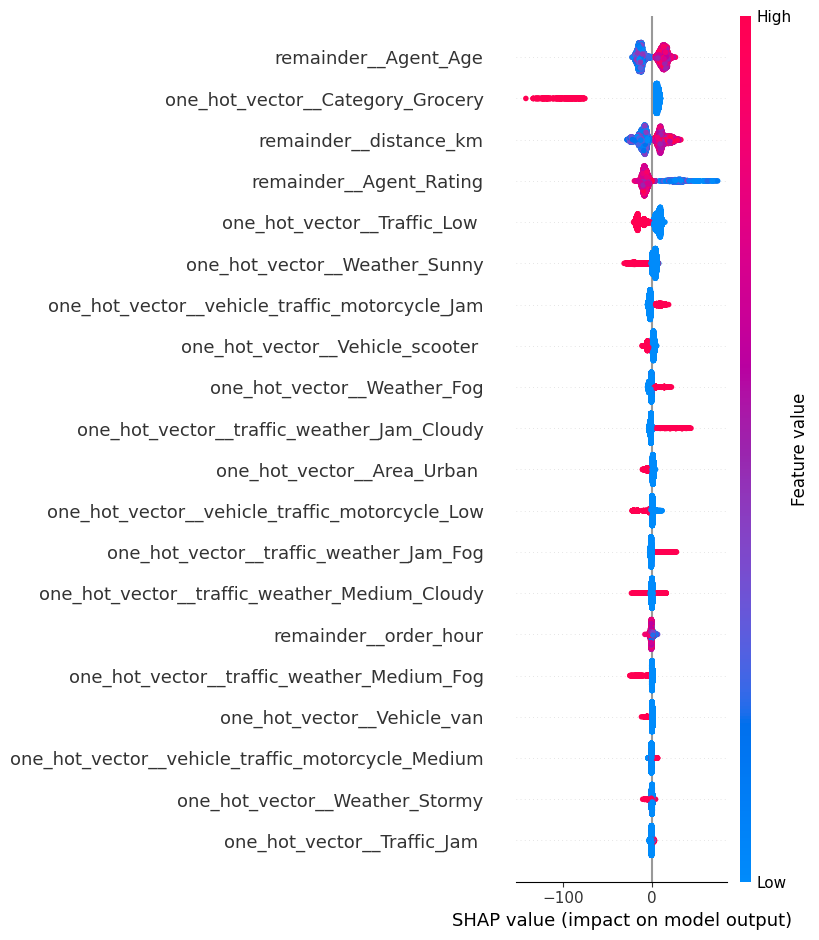

In [85]:
import shap
explainer = shap.TreeExplainer(pipe.named_steps['trf3'])
shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=pipe.named_steps['trf1'].get_feature_names_out())

In [87]:
import joblib
pipe = joblib.dump(pipe, "xgb_pipeline_final.joblib")